In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [24]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [23]:
df = pd.read_csv("Delhi/aqi_predicted_new.csv", parse_dates=["Datetime"])
# result = df[['AQI_calculated', 'AQI_bucket_calculated']]
# df = df.drop(columns=['AQI_calculated', 'AQI_bucket_calculated'])

In [ ]:
df.columns.values

In [5]:
df = df.drop(columns=['Compare'])

In [8]:
df.head()

,Datetime,AQI_original,AQI_bucket_original,AQI_predicted,AQI_bucket_predicted,Result
0,2015-01-01 16:00:00,714,Severe,693.35974,Severe,Match
1,2015-01-01 17:00:00,683,Severe,665.10080,Severe,Match
2,2015-01-01 18:00:00,662,Severe,645.80040,Severe,Match
3,2015-01-01 19:00:00,659,Severe,643.03340,Severe,Match
4,2015-01-01 20:00:00,664,Severe,647.64400,Severe,Match


In [7]:
# Create the Result column based on the comparison of original and predicted columns
df['Result'] = np.where(df['AQI_bucket_predicted'] == df['AQI_bucket_original'], 'Match', 'Mismatched')

In [9]:
aqi = df[["AQI_bucket_original", "AQI_bucket_predicted"]]
result = df["Result"]
aqi

,AQI_bucket_original,AQI_bucket_predicted
0,Severe,Severe
1,Severe,Severe
2,Severe,Severe
3,Severe,Severe
4,Severe,Severe
...,...,...
48172,Satisfactory,Satisfactory
48173,Satisfactory,Satisfactory
48174,Satisfactory,Satisfactory
48175,Satisfactory,Satisfactory


In [10]:
matching_count = (aqi['AQI_bucket_predicted'] == aqi['AQI_bucket_original']).sum()
mismatching_count = len(aqi['AQI_bucket_predicted']) - matching_count

In [11]:
counter = {
  "Matching": matching_count,
  "Mismatching": mismatching_count,
  "Original": len(aqi)
}

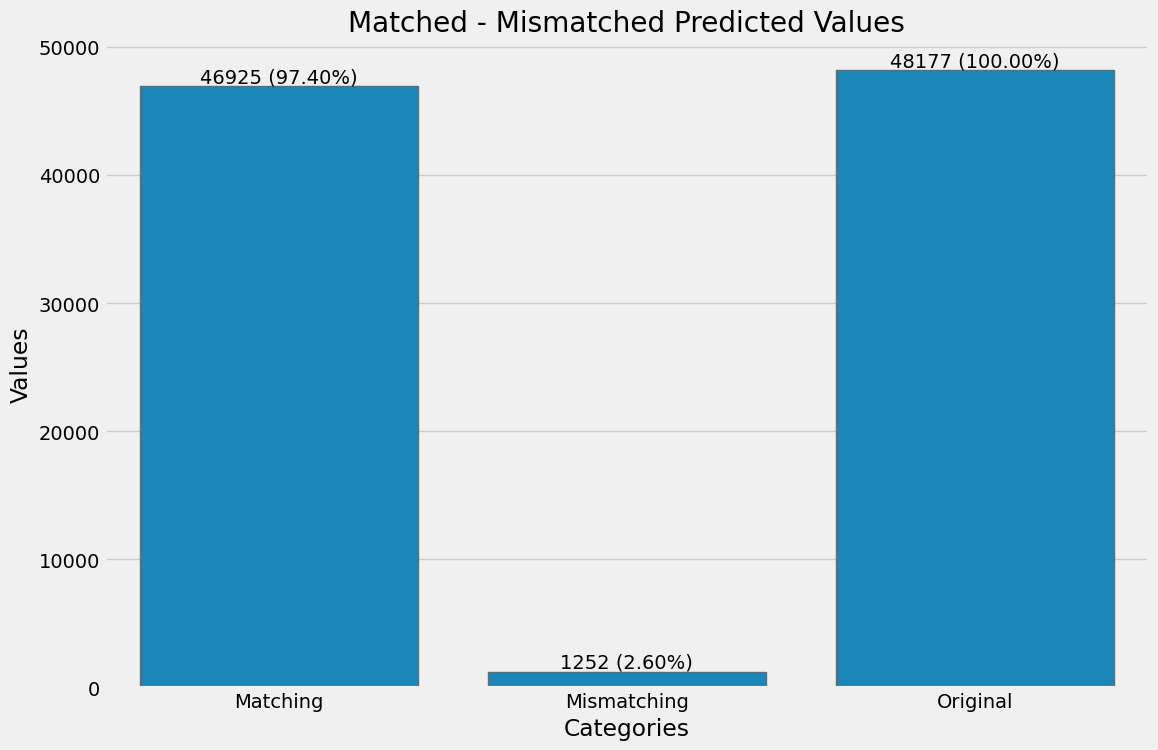

In [14]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(counter.items()), columns=["Category", "Value"])

plt.figure(figsize=(12,8))
# Create bar plot using Seaborn
sns.barplot(x="Category", y="Value", data=df)

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Matched - Mismatched Predicted Values")

# # Annotate each bar with its value
# for index, value in enumerate(df["Value"]):
#     plt.text(index, value, str(value), ha="center", va="bottom")
# Annotate each bar with its value and percentage
for index, row in df.iterrows():
    value = row["Value"]
    percentage = (value / len(aqi)) * 100
    plt.text(index, value, f"{value} ({percentage:.2f}%)", ha="center", va="bottom")

# Show plot
plt.show()

In [15]:
# Count occurrences of each unique value in 'Column1'
predicted_value_counts = aqi['AQI_bucket_predicted'].value_counts()
original_value_counts = aqi['AQI_bucket_original'].value_counts()

print("Occurrences of each unique value in 'Column1':")
print(original_value_counts)
print(predicted_value_counts)

Occurrences of each unique value in 'Column1':
AQI_bucket_original
Moderate        14872
Very Poor       14398
Poor             9229
Satisfactory     4983
Severe           4342
Good              353
Name: count, dtype: int64
AQI_bucket_predicted
Moderate        14969
Very Poor       14067
Poor             9684
Satisfactory     4985
Severe           4119
Good              353
Name: count, dtype: int64


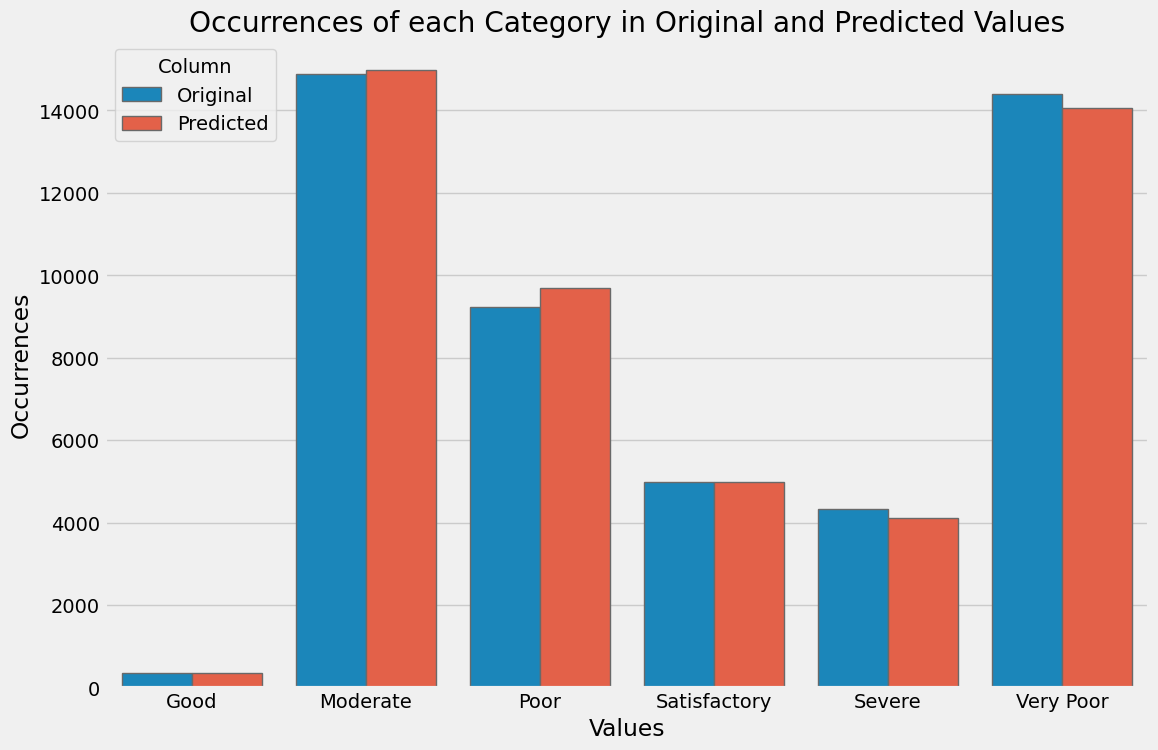

In [16]:
# Concatenate 'original' and 'predicted' columns
combined_series = pd.concat([aqi["AQI_bucket_original"], aqi["AQI_bucket_predicted"]])

# Count occurrences of each unique value in 'original' and 'predicted' columns
original_counts = aqi["AQI_bucket_original"].value_counts().sort_index()
predicted_counts = aqi["AQI_bucket_predicted"].value_counts().sort_index()

# Create a DataFrame to store the counts for each category
category_counts = pd.DataFrame(
    {
        "Value": original_counts.index,
        "Original": original_counts.values,
        "Predicted": predicted_counts.values,
    }
)

# Melt the DataFrame to long format for plotting
category_counts = pd.melt(
    category_counts, id_vars=["Value"], var_name="Column", value_name="Occurrences"
)

plt.figure(figsize=(12, 8))

# Create bar plot using Seaborn
sns.barplot(x="Value", y="Occurrences", hue="Column", data=category_counts)

# Annotate each bar with its value
# for index, row in category_counts.iterrows():
#     plt.text(
#         index, row["Occurrences"], f"{row['Occurrences']}", color="black", ha="center"
#     )

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Occurrences")
plt.title("Occurrences of each Category in Original and Predicted Values")


# Show plot
plt.show()

In [17]:
category_counts

,Value,Column,Occurrences
0,Good,Original,353
1,Moderate,Original,14872
2,Poor,Original,9229
3,Satisfactory,Original,4983
4,Severe,Original,4342
5,Very Poor,Original,14398
6,Good,Predicted,353
7,Moderate,Predicted,14969
8,Poor,Predicted,9684
9,Satisfactory,Predicted,4985


## AQI Calculate

In [ ]:
df.head()

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["AQI_bucket_predicted"] = df["AQI_predicted"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_predicted.isna()].head(13)

In [ ]:
df.to_csv("Delhi/aqi_predicted_new.csv", index=False)

In [ ]:
df['Date']=df["Datetime"].dt.date
df['Month']=df["Datetime"].dt.month
df['Year']=df["Datetime"].dt.year
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day

In [ ]:
df.info()

In [ ]:
df = df[
    ["Datetime", "O3", "CO", "NO2", "SO2", "NO", "NOx", "PM2.5", "PM10", "NH3","AQI"]
]
df2 = df.groupby(["Datetime"]).mean()
df2.head()

# AQI Prediction

In [ ]:
df = pd.read_csv("Delhi/aqi_calculated.csv", parse_dates=["Datetime"])

In [25]:
df.head()

,Datetime,AQI_original,AQI_bucket_original,AQI_predicted,AQI_bucket_predicted,Compare
0,2015-01-01 16:00:00,714,Severe,693.35974,Severe,NaN
1,2015-01-01 17:00:00,683,Severe,665.10080,Severe,NaN
2,2015-01-01 18:00:00,662,Severe,645.80040,Severe,NaN
3,2015-01-01 19:00:00,659,Severe,643.03340,Severe,NaN
4,2015-01-01 20:00:00,664,Severe,647.64400,Severe,NaN


In [27]:
# log transformation to deal with skewed data

aqi = np.log1p(df[['AQI_original']].values)
aqi.shape

(48177, 1)

<Figure size 1200x500 with 0 Axes>

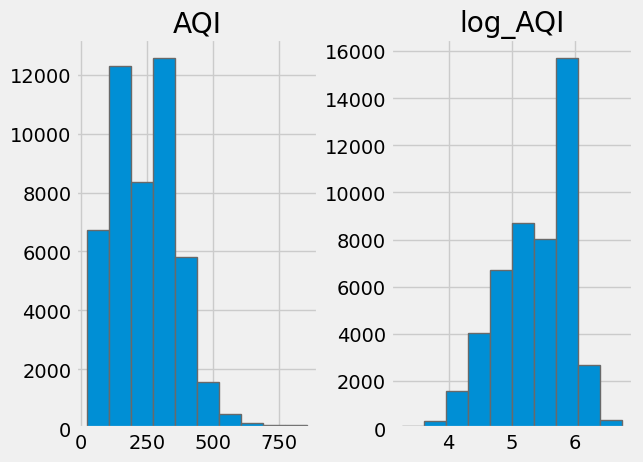

In [29]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'AQI' : df['AQI_original'].values, 'log_AQI' : aqi[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [30]:
# split into train and test sets
# 80% for training, 20% for testing

train_size = int(len(aqi) * 0.8)
test_size = len(aqi) - train_size
train, test = aqi[0:train_size, :], aqi[train_size : len(aqi), :]
print(len(train), len(test))

38541 9636


In [31]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [32]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print("Shape of trainX :", trainX.shape)
print("Shape of trainY :", trainY.shape)
print("Shape of testX :", testX.shape)
print("Shape of testY :", testY.shape)

Shape of trainX : (38539, 1)
Shape of trainY : (38539,)
Shape of testX : (9634, 1)
Shape of testY : (9634,)


In [33]:
# reshape the input array to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("Shape of trainX :", trainX.shape)
print("Shape of testX :", testX.shape)

Shape of trainX : (38539, 1, 1)
Shape of testX : (9634, 1, 1)


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, batch_size=1, epochs=1)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))

In [ ]:
train_aqi = pd.DataFrame(trainPredict, columns=['AQI'])
test_aqi = pd.DataFrame(testPredict, columns =['AQI'])
print(len(train_aqi))
print(len(test_aqi))

In [ ]:
train_aqi.to_csv("Delhi/train_aqi.csv", index=False)
test_aqi.to_csv("Delhi/test_aqi.csv", index=False)

In [34]:
train = pd.read_csv("Delhi/train_aqi.csv")
test = pd.read_csv("Delhi/test_aqi.csv")
look_back = 1

(38000.0, 49000.0)

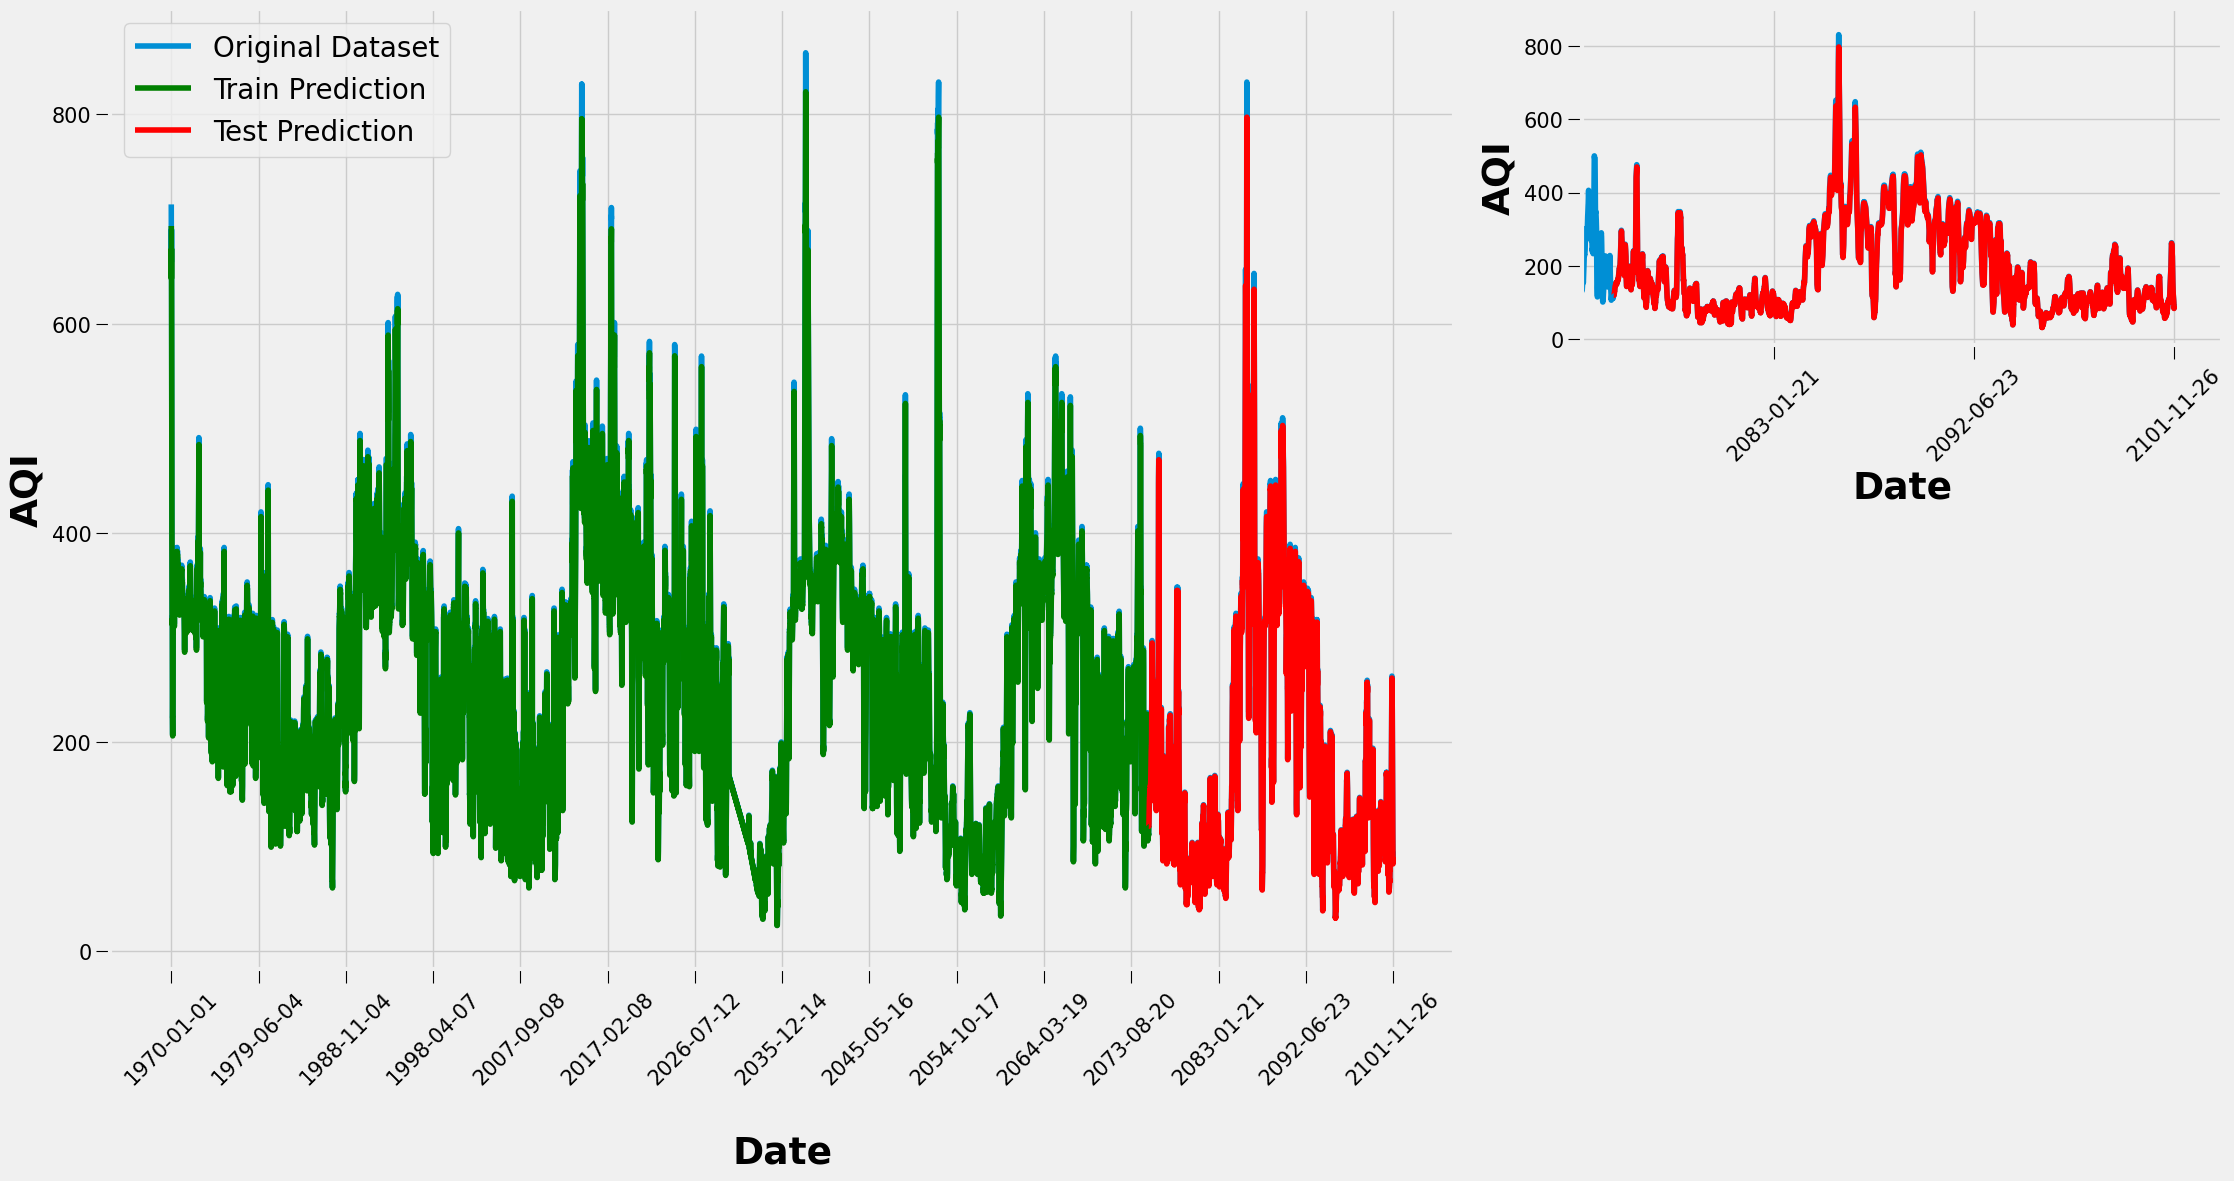

In [35]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(aqi)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train) + look_back, :] = train

# shift test predictions for plotting
testPredictPlot = np.empty_like(aqi)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train) + (look_back * 2) + 1 : len(aqi) - 1, :] = (
    test
)

# plot original dataset and predictions
time_axis = np.linspace(0, aqi.shape[0] - 1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df.index, dtype="datetime64[D]")

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(aqi), label="Original Dataset")
ax.plot(trainPredictPlot, color="green", label="Train Prediction")
ax.plot(testPredictPlot, color="red", label="Test Prediction")
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel("\nDate", fontsize=27, fontweight="bold")
ax.set_ylabel("AQI", fontsize=27, fontweight="bold")
ax.legend(loc="best", prop={"size": 20})
ax.tick_params(size=10, labelsize=15)
# ax.set_xlim([-1, 1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(aqi), label="Original Dataset")
ax1.plot(testPredictPlot, color="red", label="Test Prediction")
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel("Date", fontsize=27, fontweight="bold")
ax1.set_ylabel("AQI", fontsize=27, fontweight="bold")
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([38000, 49000])

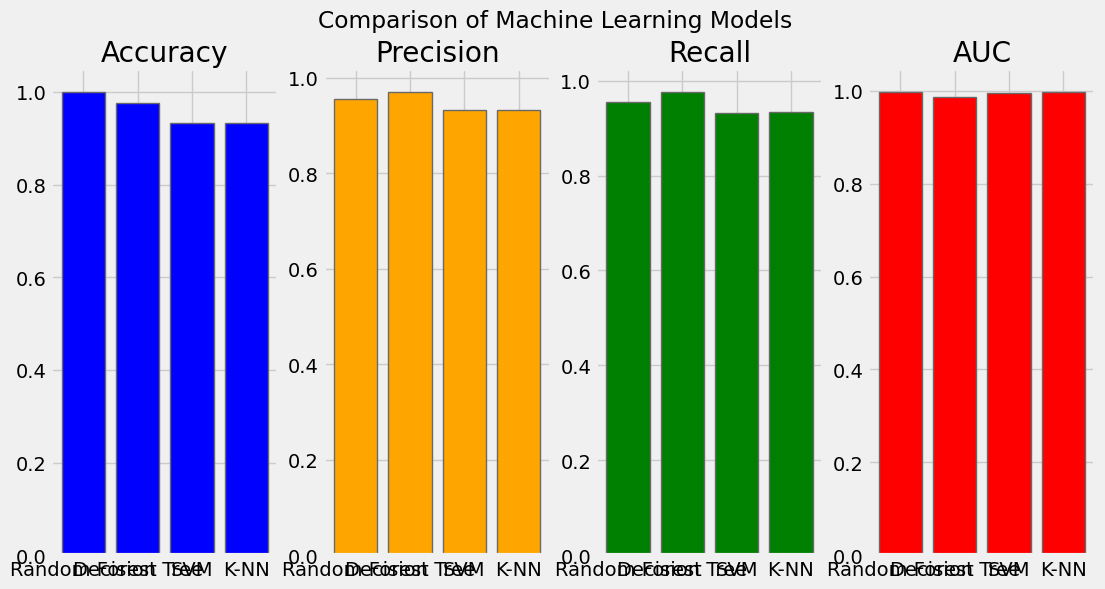

In [38]:
import matplotlib.pyplot as plt

# Data
models = ['Random Forest', 'Decision Tree', 'SVM', 'K-NN']
accuracy = [0.9993, 0.9754, 0.9322, 0.933]
precision = [0.9551, 0.9699, 0.9318, 0.9329]
recall = [0.9551, 0.9754, 0.9322, 0.933]
auc = [0.9972, 0.9871, 0.9965, 0.9968]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.bar(models, accuracy, color='blue')
plt.title('Accuracy')

plt.subplot(1, 4, 2)
plt.bar(models, precision, color='orange')
plt.title('Precision')

plt.subplot(1, 4, 3)
plt.bar(models, recall, color='green')
plt.title('Recall')

plt.subplot(1, 4, 4)
plt.bar(models, auc, color='red')
plt.title('AUC')

plt.suptitle('Comparison of Machine Learning Models')
plt.show()


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(aqi)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(aqi)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1 : len(aqi) - 1, :] = (
    testPredict
)

# plot original dataset and predictions
time_axis = np.linspace(0, aqi.shape[0] - 1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df.index, dtype="datetime64[D]")

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(aqi), label="Original Dataset")
ax.plot(trainPredictPlot, color="green", label="Train Prediction")
ax.plot(testPredictPlot, color="red", label="Test Prediction")
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel("\nDate", fontsize=27, fontweight="bold")
ax.set_ylabel("AQI", fontsize=27, fontweight="bold")
ax.legend(loc="best", prop={"size": 20})
ax.tick_params(size=10, labelsize=15)
# ax.set_xlim([-1, 1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(aqi), label="Original Dataset")
ax1.plot(testPredictPlot, color="red", label="Test Prediction")
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel("Date", fontsize=27, fontweight="bold")
ax1.set_ylabel("AQI", fontsize=27, fontweight="bold")
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([38000, 49000])

## Other test

In [ ]:
plt.figure(figsize=(16,6))
plt.title('AQI')
plt.plot(df2['AQI_calculated'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['AQI_calculated'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [ ]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model2.fit(x_train, y_train, batch_size=1, epochs=1)

In [ ]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model2.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# make predictions
trainPredict = model2.predict(x_train)
testPredict = model2.predict(x_test)

# invert predictions
trainPredict = np.expm1(trainPredict)
y_train = np.expm1(y_train)
testPredict = np.expm1(testPredict)
y_test = np.expm1(y_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
test_series = pd.Series(y_test)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('AQI Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.plot(train['AQI_calculated'])
plt.plot(valid[['AQI_calculated', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()